# TFIDF基线模型 + top选最长
当前最佳得分模型

tfidf模型，主要思路是：首先计算用户的问题与问题库中的问题的相似度并选出top15的相似问题，然后去问题库对应的答案库中找出这15个问题对应的答案， 以此作为回答用户问题的候选答案。代码参考：https://github.com/WenDesi/sentenceSimilarity 运行于python3.6环境下。

用TFIDF方法做检索，其基本过程如下：
假设输入查询为query，query中包含n个词语，分别是q1、q2、…、qn；语料库为D，包含若干个句子。

step 1. 对语料库D中的所有句子进行分词；

step 2. 构建bag-of-word模型，给每个词一个id；

step 3. 计算语料库D中所有词的tfidf值；

step 4. 计算语料库D中所有句子的tfidf向量表达；

对于任一句子，其tfidf向量表达是句子中所有词的tfidf值构成的向量，保留词的先后顺序。
step 5. 对query分词，生成tfidf向量表达，计算该向量与语料库D中所有句子向量的相似度，选取top N作为检索结果。

基于TFIDF检索式方案，生成结果的方式默认是直接选择最相似的对话的A作为结果输出，这样做的问题是选择范围过于狭小。事实上，根据我们的观察，相似性top10的对话其实都比较接近，难以评判哪一个是最相似，因此，我们认为在top10相似对话的所有A中产生结果更为合理。

随之而来的问题是，如何在10个候选结果中找出最好的结果，使得deltaBleu得分最高？最开始，我们采用强化学习中的DQN方法来进行选择，直接采用bleu得分作为奖励，但是并没有带来有效的提升，甚至得分下降。针对这种情况，我们分析的结论是：DQN的目标是优化长期奖励，不适用这种仅有一个回合的场景。使用强化学习的方案遇挫，我们不得不重新回到数据上寻找答案。**在逐个观察了约100个用户与客服的完整对话记录之后，我们发现，客服的回复通常倾向于比用户说的话更长，这个现象带来的启发是：在10个候选答案中选择最长的。**经测试，top10选最长的方案，大幅提升了deltaBleu评测得分，甚至一度冲上初赛排行榜第2名。

In [1]:
# coding=utf-8
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re
# import sklearn


data_chat = pd.read_csv("../data/JDDC_100W训练数据集/训练数据集/chat_1per.txt", sep = "\t", engine="python", 
                        warn_bad_lines = True, error_bad_lines = False, encoding = "UTF-8", header = None)

n_row = data_chat.shape[0]
print(n_row)

131411


## 结巴分词，创建语料库
	这里做的工作很简单，就是将所有句子分句储存在texts中，text是一个list list对象

## 根据语料库，创建词典

In [4]:
import jieba
import time
from gensim import corpora, models, similarities

time_start=time.time()

texts = []
for i in range(n_row):
    sentence = data_chat.iat[i, 6]
    list_word = list(jieba.cut(sentence))
    texts.append(list_word)
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=3, no_above=0.5, keep_n=100000, keep_tokens=None)
corpus_simple = [dictionary.doc2bow(text) for text in texts]
print(corpus_simple[0])

time_end=time.time()
print('time cost',time_end-time_start,'s')

[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2)]
time cost 12.718607425689697 s


## 计算tfidf

In [6]:
time_start=time.time()

tfidf = models.TfidfModel(corpus_simple)
corpus = tfidf[corpus_simple]
# print(len(corpus[0]))
# print(corpus[0])
# print(len(corpus[1]))
# print(corpus[1])
# print(len(corpus[2]))
# print(corpus[2])

time_end=time.time()
print('time cost',time_end-time_start,'s')

time cost 0.2532939910888672 s


## 计算相似度矩阵

In [8]:
time_start=time.time()

index = similarities.MatrixSimilarity(corpus)
# index = similarities.SparseMatrixSimilarity(corpus)


# with open("../data/JDDC_100W训练数据集/训练数据集/corpus_simple.pkl", 'w') as f:
#     pickle.dump([dictionary, corpus_simple], f)
tfidf.save("../data/JDDC_100W训练数据集/训练数据集/tfidf.model")
index.save("../data/JDDC_100W训练数据集/训练数据集/index.index")


time_end=time.time()
print('time cost',time_end-time_start,'s')

MemoryError: 

## 句子相似度

In [5]:
# from .utils import Sentence

## 先使用sentence2vec将需要匹配的句子传进去
def sentence2vec(sentence):
    list_word = list(jieba.cut(sentence))
    vec_bow = dictionary.doc2bow(list_word)
    return tfidf[vec_bow]

def similarity(sentence, top=15):
    """求最相似的句子"""
    sentence_vec = sentence2vec(sentence)
    sims = index[sentence_vec]

    # 按相似度降序排序
    sim_sort = sorted(list(enumerate(sims)), key=lambda item: item[1], reverse=True)
    top_15 = sim_sort[0:top]

    return top_15

In [9]:
result = similarity("你好，请问增值税专用发票可以开吧")
print(result)
for answer in result:
    print(data_chat.iat[answer[0]+1, 6])

[(8, 0.96259785), (20197, 0.8543315), (28126, 0.85146356), (63582, 0.76005137), (36310, 0.7396598), (47810, 0.7396598), (57169, 0.7396598), (102335, 0.72044456), (45708, 0.7111318), (21261, 0.7070372), (55965, 0.6933076), (123209, 0.6833998), (102534, 0.67431927), (91662, 0.67117685), (25957, 0.66524637)]
您资质过了吗亲
好的 收到
亲可以在订单下载的
亲爱的，增票开出的周期是您资质审核通过的情况下，订单完成之后γ个工作日开具并寄出，麻烦您注意查收哦~
一般订单完成γ-γ个工作日开具
亲 很抱歉 开不了呢
好的  稍等哦
是的
您提供下订单号呢 刚刚   戴尔(DELL)UγDR γ英寸γK分辨率四边微边框旋转升降IPS屏 HDR 爱眼护眼滤蓝光吃鸡显示器(带HDMI线
您好，APP端麻烦您点击对话框右下角的“+”，点击“订单”后，选择一下您需要咨询的订单哦，PC端在我的订单中查看，还请您点击复制给我一下哈，小妹这边帮您查询哦~
您好，增票是您这在这里ε，下单选增票，订单完成之后γ-γ工作日京东为您开具寄出的呢!
亲亲，您能把您订单号给我一下吗
您好，开增票需要在:我的京东-账户设置-增票资质，填写您开具增值税专用发相关信息的，填写提交之后γ个工作日内审核
好的 等待订单完成为您申请修改 增票一般是在订单完成状态 并且您的账户增票资质也验证通过后 γ-γ个工作日为您开具，邮寄的哦!
β


## 余弦相似度函数

In [18]:
import jieba

def get_word_vector(s1,s2):
    """
    :param s1: 句子1
    :param s2: 句子2
    :return: 返回句子的余弦相似度
    """
    # 分词
    cut1 = jieba.cut(s1)
    cut2 = jieba.cut(s2)
    list_word1 = (','.join(cut1)).split(',')
    list_word2 = (','.join(cut2)).split(',')

    # 列出所有的词,取并集
    key_word = list(set(list_word1 + list_word2))
    # 给定形状和类型的用0填充的矩阵存储向量
    word_vector1 = np.zeros(len(key_word))
    word_vector2 = np.zeros(len(key_word))

    # 计算词频
    # 依次确定向量的每个位置的值
    for i in range(len(key_word)):
        # 遍历key_word中每个词在句子中的出现次数
        for j in range(len(list_word1)):
            if key_word[i] == list_word1[j]:
                word_vector1[i] += 1
        for k in range(len(list_word2)):
            if key_word[i] == list_word2[k]:
                word_vector2[i] += 1

    # 输出向量
#     print(word_vector1)
#     print(word_vector2)
    return word_vector1, word_vector2

def cos_dist(s1, s2):
    """
    :param vec1: 向量1
    :param vec2: 向量2
    :return: 返回两个向量的余弦相似度
    """
    vec1, vec2 = get_word_vector(s1, s2)
    dist1= float(np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
    return dist1

print(cos_dist("我喜欢", "我也喜欢"))

0.8164965809277259


In [29]:
print(data_chat.iat[result[0][0]+1, 6])
print(cos_dist(data_chat.iat[result[0][0]+1, 6], data_chat.iat[result[1][0]+1, 6]))


x_sim = np.zeros((len(result), len(result)))
for i in range(len(result)):
    for j in range(len(result)):
        if i != j:
            x_sim[i][j] = cos_dist(data_chat.iat[result[i][0]+1, 6], data_chat.iat[result[j][0]+1, 6]);
#             print("i j: " + str(i) + " " + str(j) + " " + str(cos_dist(data_chat.iat[result[i][0]+1, 6], data_chat.iat[result[j][0]+1, 6])))

print(x_sim)

您资质过了吗亲
0.0
[[0.         0.         0.16666667 0.18057878 0.         0.12909944
  0.         0.         0.0421076  0.14490471 0.12751534 0.33968311
  0.12171612 0.18609684 0.        ]
 [0.         0.         0.20412415 0.22116293 0.         0.31622777
  0.66666667 0.35355339 0.36099744 0.13310348 0.07808688 0.
  0.1490712  0.45584231 0.        ]
 [0.16666667 0.20412415 0.         0.24077171 0.12309149 0.12909944
  0.13608276 0.28867513 0.         0.25358324 0.19127301 0.
  0.18257419 0.27914526 0.        ]
 [0.18057878 0.22116293 0.24077171 0.         0.31118796 0.
  0.19658927 0.41702883 0.09124486 0.54950103 0.64474382 0.28625129
  0.52750438 0.55448482 0.        ]
 [0.         0.         0.12309149 0.31118796 0.         0.
  0.         0.         0.18659112 0.08026442 0.42379345 0.
  0.26967994 0.44668529 0.        ]
 [0.12909944 0.31622777 0.12909944 0.         0.         0.
  0.42163702 0.         0.48924605 0.         0.04938648 0.
  0.         0.28829999 0.        ]
 [0.        

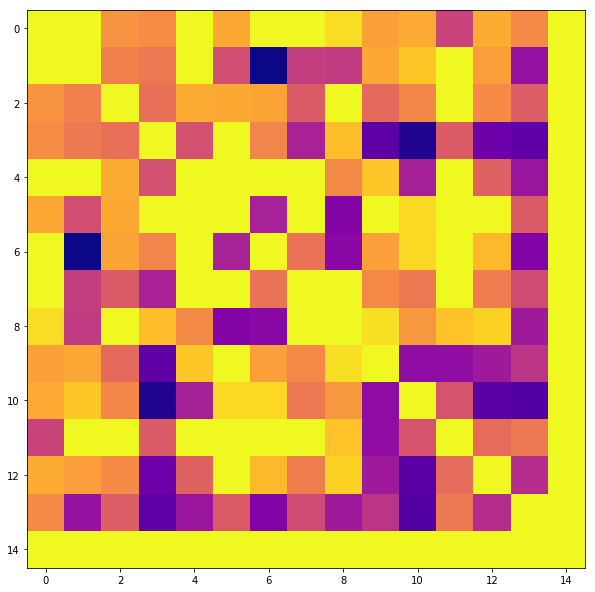

In [30]:
from matplotlib import pyplot as plt
fig,ax=plt.subplots(figsize=(10,20))
im=ax.imshow(x_sim,cmap='plasma_r')
plt.show()

## result
我们从top15中选取result的方式是选取和其他句子相似度和最大的。  
从heatmap可以看出，13th句子和其他句子有最大相似度，其内容非常匹配Q。

In [ ]:
x_sum = np.zeros((len(result, 0)))
for i in range(len(result)):
    x_sum[i] = x_sim[i].sum()
n_result = np.argmax(x_sum)
print(n_result, data_chat.iat[result[n_result][0]+1, 6])